In [3]:
cd /content/drive/MyDrive/CVL

/content/drive/MyDrive/CVL


In [4]:
!ls

Authors				    model_cvl_EuclideanContrastive.pt
AuthorsDatasetFromDictionary.py     __pycache__
contrastiveCosineSiameseNetwork.py  test_1000_03052021.txt
ContrastiveLoss.py		    train_10000_03052021.txt
ContrastiveLossWithCosine.py	    valid_1000_03052021.txt
contrastiveSiameseNetwork.py


In [7]:
from time import sleep
from threading import Thread
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from contrastiveCosineSiameseNetwork import *
from ContrastiveLossWithCosine import *
from torchsummary import summary
from matplotlib import pyplot as plt
from AuthorsDatasetFromDictionary import *
!pip install hdf5storage
import hdf5storage
from skimage import io, transform, color,img_as_ubyte

In [8]:
torch.cuda.is_available()

True

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 15:17:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
ImageDictionary = {}

folders = os.listdir(os.path.join('','Authors'))
shuffleArray = folders
random.shuffle(shuffleArray) #inplace shuffling.

pt1ranges = (0,25)
pt2ranges = (25,50)
pt3ranges = (50,75)
pt4ranges = (75,100)
def readTo(shufflearray ,ranges,readinto):
    for folderId in range(ranges[0],ranges[1]):
        files = os.listdir(os.path.join('','Authors',shufflearray[folderId])) 
        for file in files :
          img = io.imread(os.path.join('','Authors',shufflearray[folderId],file))
          img = color.rgb2gray(img)
          img = img_as_ubyte(img)
          readinto[os.path.join('','Authors',shufflearray[folderId],file)] = img
        print(str(folderId) , "is done...")

pt1 = Thread(target = readTo, args = (shuffleArray,pt1ranges,ImageDictionary))
pt2 = Thread(target = readTo, args = (shuffleArray,pt2ranges,ImageDictionary))
pt3 = Thread(target = readTo, args = (shuffleArray,pt3ranges,ImageDictionary))
pt4 = Thread(target = readTo, args = (shuffleArray,pt4ranges,ImageDictionary))

pt1.start()
pt2.start()
pt3.start()
pt4.start()

pt1.join()
pt2.join()
pt3.join()
pt4.join()

0 is done...
50 is done...
75 is done...
25 is done...
51 is done...
76 is done...
26 is done...
1 is done...
77 is done...
52 is done...
27 is done...
2 is done...
53 is done...
78 is done...
28 is done...
3 is done...
54 is done...
29 is done...
79 is done...
4 is done...
30 is done...
55 is done...
80 is done...
5 is done...
56 is done...
31 is done...
81 is done...
6 is done...
57 is done...
32 is done...
82 is done...
7 is done...
83 is done...
33 is done...
58 is done...
8 is done...
34 is done...
84 is done...
59 is done...
9 is done...
35 is done...
85 is done...
10 is done...
60 is done...
36 is done...
86 is done...
11 is done...
37 is done...
61 is done...
87 is done...
12 is done...
38 is done...
62 is done...
88 is done...
39 is done...
13 is done...
63 is done...
89 is done...
40 is done...
14 is done...
90 is done...
15 is done...
41 is done...
64 is done...
91 is done...
16 is done...
42 is done...
65 is done...
92 is done...
17 is done...
43 is done...
66 is done...
18

In [11]:
root_dir='./'
pathTrain ='/content/drive/MyDrive/CVL/train_10000_03052021.txt'
pathValid ='/content/drive/MyDrive/CVL/valid_1000_03052021.txt'

# Constants from Authors100 dataset
MAXWIDTH = 2387
MAXHEIGHT = 200

train_ds = AuthorsDataset(
    root_dir=root_dir,
    path=pathTrain,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=True),
        Downsample(0.75),
    ]))
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path=pathValid,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

In [12]:
## Initialize parameters
bs = 128
lr = 0.00006
threshold = 0.05
margin = 0.15
epochs = 100

In [13]:
## Initialize network
model = ContrastiveCosineSiamese()
model = model.cuda()


In [14]:
## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize loss
criterion = ContrastiveLossWithCosine(margin)

In [15]:
train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)

In [16]:
images1, images2, labels = next(iter(train_dl))
images1.shape

torch.Size([128, 1, 150, 150])

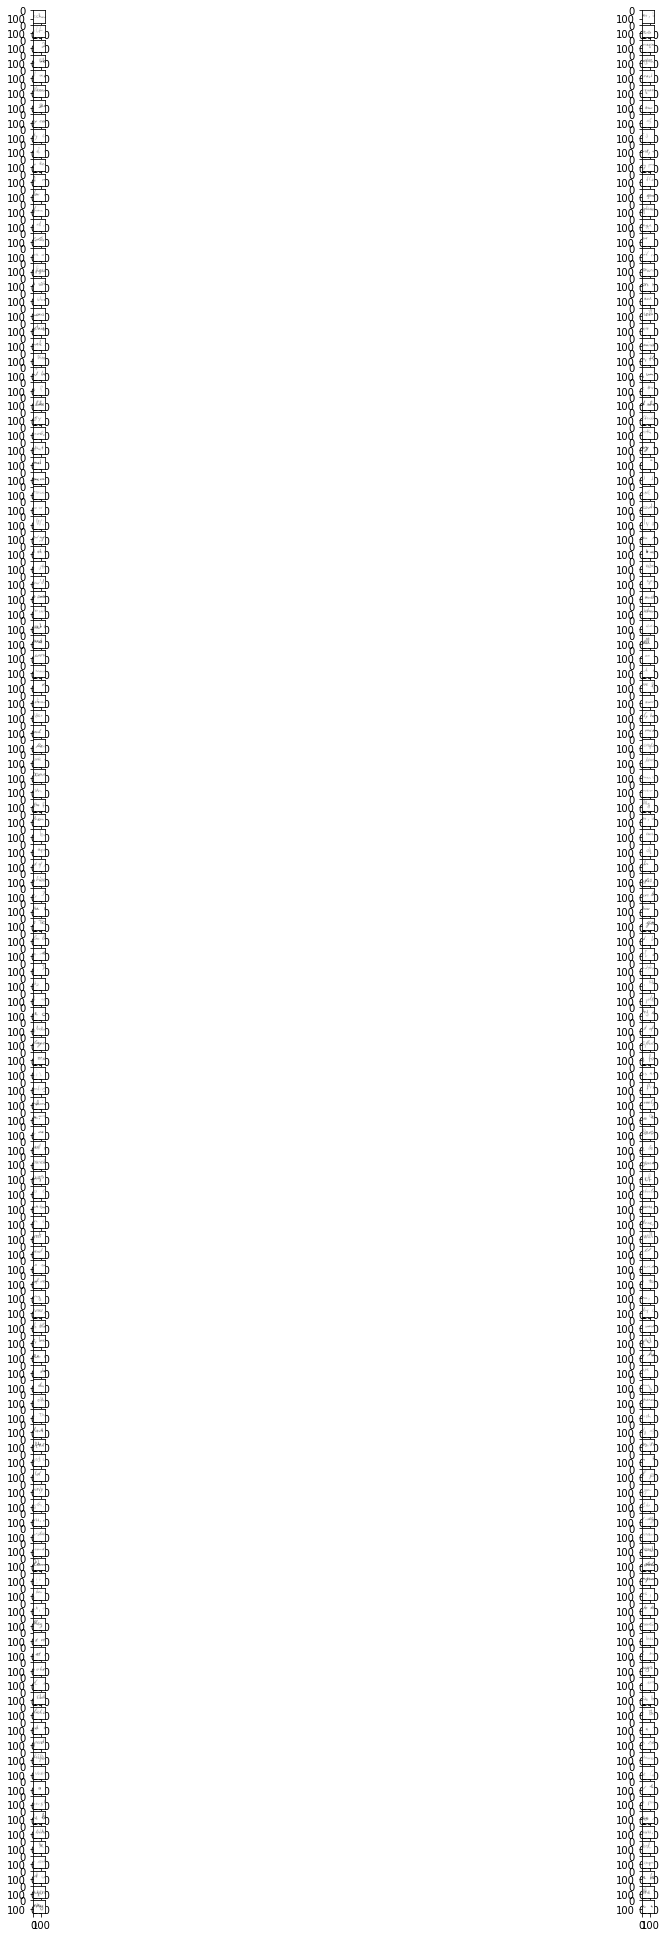

In [17]:
images1, images2, labels = next(iter(train_dl))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,35)

fig, axs = plt.subplots(bs, 2)
for ii in range(bs):
    axs[ii, 0].imshow(torch.squeeze(images1[ii]), cmap ='gray')
    axs[ii, 1].imshow(torch.squeeze(images2[ii]), cmap ='gray')

In [18]:
def evaluate_pair_cosine(output1,output2,target,threshold):
    cos_similarity = nn.CosineSimilarity(dim=1, eps=1e-8)
    cos_similarity_score = cos_similarity(output1 , output2)
    cos_distance = 1 - cos_similarity_score
    cond = cos_distance<threshold
    TruePositive = 0
    FalsePositive = 0
    TrueNegative = 0
    FalseNegative = 0



    for i in range(len(cond)):
        if target[i] == True and cond[i] == True:
            TruePositive += 1
        elif target[i] == True and cond[i] == False:
            FalseNegative +=1
        elif target[i] == False and cond[i] == True:
            FalsePositive +=1
        else:
            TrueNegative +=1
    return TruePositive,FalsePositive,TrueNegative,FalseNegative

In [19]:
train_loss = []
valid_loss = []
valid_acc = []
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.cuda(),input2.cuda())
        
        loss = criterion(output1,output2,target.cuda())
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),threshold)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)
    

    valid_loss.append(valid_epoch_loss)
    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)
    valid_acc.append(valid_acc_value)


    print("Validation loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n Validation Datasize: {}\n".format(valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value,len(valid_ds)))
    # save model if Training loss has decreased
    if valid_epoch_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_epoch_loss))
        torch.save(model.state_dict(), 'model_iam_epoch{}.pt'.format(epoch))
        valid_loss_min = valid_epoch_loss


Epoch [1/100] ----> Training loss :0.0005844588503241539 

Validation loss :0.00047747314348816874 			  TP: 463, TN: 164, FP: 336, FN: 37, Accuracy = 0.627
 Validation Datasize: 1000

Validation loss decreased (inf --> 0.000477).  Saving model ...
Epoch [2/100] ----> Training loss :0.0004175011210143566 

Validation loss :0.0003778888545930386 			  TP: 407, TN: 307, FP: 193, FN: 93, Accuracy = 0.714
 Validation Datasize: 1000

Validation loss decreased (0.000477 --> 0.000378).  Saving model ...
Epoch [3/100] ----> Training loss :0.00037670339085161685 

Validation loss :0.0003751987293362618 			  TP: 397, TN: 317, FP: 183, FN: 103, Accuracy = 0.714
 Validation Datasize: 1000

Validation loss decreased (0.000378 --> 0.000375).  Saving model ...
Epoch [4/100] ----> Training loss :0.00037468355614691975 

Validation loss :0.0003736506216228008 			  TP: 421, TN: 299, FP: 201, FN: 79, Accuracy = 0.72
 Validation Datasize: 1000

Validation loss decreased (0.000375 --> 0.000374).  Saving mode

In [20]:
model = ContrastiveCosineSiamese()
model.load_state_dict(torch.load('/content/drive/MyDrive/CVL/model_iam_epoch99.pt'))
model = model.cuda()

In [21]:
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/CVL/valid_1000_03052021.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

valid_dl = DataLoader(valid_ds,batch_size=bs)


In [22]:
tresholds = [0.005,0.004,0.003,0.002,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\t Validation loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.005	 Validation loss :0.0002198405731469393 			  TP: 130, TN: 492, FP: 8, FN: 370, Accuracy = 0.622

Tresholds:0.004	 Validation loss :0.0002198405731469393 			  TP: 110, TN: 493, FP: 7, FN: 390, Accuracy = 0.603

Tresholds:0.003	 Validation loss :0.0002198405731469393 			  TP: 92, TN: 496, FP: 4, FN: 408, Accuracy = 0.588

Tresholds:0.002	 Validation loss :0.0002198405731469393 			  TP: 69, TN: 496, FP: 4, FN: 431, Accuracy = 0.565

Tresholds:0.001	 Validation loss :0.0002198405731469393 			  TP: 35, TN: 497, FP: 3, FN: 465, Accuracy = 0.532

Tresholds:0.01	 Validation loss :0.0002198405731469393 			  TP: 209, TN: 484, FP: 16, FN: 291, Accuracy = 0.693

Tresholds:0.02	 Validation loss :0.0002198405731469393 			  TP: 298, TN: 470, FP: 30, FN: 202, Accuracy = 0.768

Tresholds:0.03	 Validation loss :0.0002198405731469393 			  TP: 361, TN: 453, FP: 47, FN: 139, Accuracy = 0.814

Tresholds:0.04	 Validation loss :0.0002198405731469393 			  TP: 398, TN: 441, FP: 59, FN: 102, Accu

In [24]:
tresholds = [0.06,0.061,0.062,0.063,0.064,0.065,0.066,0.067,0.068,0.069]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\tTraining loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.06	Training loss :0.0002198405731469393 			  TP: 436, TN: 423, FP: 77, FN: 64, Accuracy = 0.859

Tresholds:0.061	Training loss :0.0002198405731469393 			  TP: 436, TN: 423, FP: 77, FN: 64, Accuracy = 0.859

Tresholds:0.062	Training loss :0.0002198405731469393 			  TP: 438, TN: 422, FP: 78, FN: 62, Accuracy = 0.86

Tresholds:0.063	Training loss :0.0002198405731469393 			  TP: 438, TN: 421, FP: 79, FN: 62, Accuracy = 0.859

Tresholds:0.064	Training loss :0.0002198405731469393 			  TP: 439, TN: 421, FP: 79, FN: 61, Accuracy = 0.86

Tresholds:0.065	Training loss :0.0002198405731469393 			  TP: 440, TN: 420, FP: 80, FN: 60, Accuracy = 0.86

Tresholds:0.066	Training loss :0.0002198405731469393 			  TP: 442, TN: 420, FP: 80, FN: 58, Accuracy = 0.862

Tresholds:0.067	Training loss :0.0002198405731469393 			  TP: 443, TN: 420, FP: 80, FN: 57, Accuracy = 0.863

Tresholds:0.068	Training loss :0.0002198405731469393 			  TP: 444, TN: 419, FP: 81, FN: 56, Accuracy = 0.863

Tresholds:0.06

In [25]:
tresholds = [0.07,0.071,0.072,0.073,0.074,0.075,0.076,0.077,0.078,0.079]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\tTraining loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.07	Training loss :0.0002198405731469393 			  TP: 446, TN: 413, FP: 87, FN: 54, Accuracy = 0.859

Tresholds:0.071	Training loss :0.0002198405731469393 			  TP: 446, TN: 412, FP: 88, FN: 54, Accuracy = 0.858

Tresholds:0.072	Training loss :0.0002198405731469393 			  TP: 449, TN: 410, FP: 90, FN: 51, Accuracy = 0.859

Tresholds:0.073	Training loss :0.0002198405731469393 			  TP: 449, TN: 410, FP: 90, FN: 51, Accuracy = 0.859

Tresholds:0.074	Training loss :0.0002198405731469393 			  TP: 451, TN: 410, FP: 90, FN: 49, Accuracy = 0.861

Tresholds:0.075	Training loss :0.0002198405731469393 			  TP: 451, TN: 409, FP: 91, FN: 49, Accuracy = 0.86

Tresholds:0.076	Training loss :0.0002198405731469393 			  TP: 451, TN: 408, FP: 92, FN: 49, Accuracy = 0.859

Tresholds:0.077	Training loss :0.0002198405731469393 			  TP: 453, TN: 407, FP: 93, FN: 47, Accuracy = 0.86

Tresholds:0.078	Training loss :0.0002198405731469393 			  TP: 453, TN: 406, FP: 94, FN: 47, Accuracy = 0.859

Tresholds:0.0

In [27]:
test_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

test_dl = DataLoader(test_ds,batch_size=bs)


TruePositiveTotal = 0
FalsePositiveTotal = 0
TrueNegativeTotal = 0
FalseNegativeTotal = 0
model.eval()

for i,(input1,input2,target) in enumerate(test_dl):
    output1,output2 = model(input1.cuda(),input2.cuda())
    loss = criterion(output1,output2,target.cuda())
    valid_epoch_loss += loss.item()
    TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),0.068)
    TruePositiveTotal += TruePositive
    FalsePositiveTotal += FalsePositive
    TrueNegativeTotal += TrueNegative
    FalseNegativeTotal += FalseNegative
    

valid_epoch_loss /= len(valid_ds)

valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)

print("Tresholds:{}\t TestSet==> TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.068,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.068	 TestSet==> TP: 436, TN: 429, FP: 71, FN: 64, Accuracy = 0.865



In [30]:
Acc_mean = 0
for a in range(10):
    test_ds  = AuthorsDataset(
        root_dir=root_dir,
        path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
        imagedict=ImageDictionary,
        transform=transforms.Compose([
            Pad((MAXWIDTH, MAXHEIGHT)),
            ShiftAndCrop(200, random=True),
            Downsample(0.75),
        ]))

    test_dl = DataLoader(test_ds,batch_size=bs)

    test_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(test_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        test_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair_cosine(output1,output2,target.cuda(),0.068)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    test_epoch_loss /= len(test_ds)

    test_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(test_ds)
    Acc_mean += test_acc_value
    print("Tresholds:{}\t TestSetLoss:{}, TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.068,test_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,test_acc_value))

print("For 10 test of random cropped test set our mean acc is {}".format(Acc_mean/10))

Tresholds:0.068	 TestSetLoss:0.00020084241591393948, TP: 449, TN: 424, FP: 76, FN: 51, Accuracy = 0.873

Tresholds:0.068	 TestSetLoss:0.00020804250799119473, TP: 447, TN: 420, FP: 80, FN: 53, Accuracy = 0.867

Tresholds:0.068	 TestSetLoss:0.00021018743142485618, TP: 457, TN: 419, FP: 81, FN: 43, Accuracy = 0.876

Tresholds:0.068	 TestSetLoss:0.00020436033979058266, TP: 449, TN: 420, FP: 80, FN: 51, Accuracy = 0.869

Tresholds:0.068	 TestSetLoss:0.00021002161130309106, TP: 444, TN: 417, FP: 83, FN: 56, Accuracy = 0.861

Tresholds:0.068	 TestSetLoss:0.00020545693300664424, TP: 447, TN: 423, FP: 77, FN: 53, Accuracy = 0.87

Tresholds:0.068	 TestSetLoss:0.00021087525598704814, TP: 453, TN: 423, FP: 77, FN: 47, Accuracy = 0.876

Tresholds:0.068	 TestSetLoss:0.00020031843520700932, TP: 455, TN: 418, FP: 82, FN: 45, Accuracy = 0.873

Tresholds:0.068	 TestSetLoss:0.00021456684358417988, TP: 443, TN: 418, FP: 82, FN: 57, Accuracy = 0.861

Tresholds:0.068	 TestSetLoss:0.000200871167704463, TP: 4